In [283]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [284]:
#Aux Functions
def comb(n, r):
    return math.factorial(n) / (math.factorial(n-r) * math.factorial(r))

def scurve(x):
    return 1 / (1 + (x / (1 - x)) ** -3)

In [285]:
#Parameteric ranges
p = np.linspace(0.01, 0.99, 101)            #Initial frequency of defender allele
q = (1 - p)                                 #Frequency of non defenders
C = 10                                      #Number of eggs laid by non defender females
c = np.linspace(1, 10, 5, dtype='int')      #Number of eggs laid by defender females
a = np.linspace(1, 10, 5, dtype='int')      #Advantage for non defender mails in mating rate
u = np.round(np.linspace(0.1, 0.9, 5), 2)   #Probability female stays unmated
r = np.round(np.linspace(0.1, 0.9, 5), 2)   #Sex ration (Prob of male larvae in a mating)

def s(d, using = 's'):                      #Probability of the group surviving based on the proportion of defenders in the larvae

    if using == 'linear':
        return d * (0.99 - 0.01) + 0.01
    elif using == 'expinv':
        return ((np.exp(-d) - np.exp(0))/(np.exp(-1) - np.exp(0))) * (0.99 - 0.01) + 0.01
    elif using == 'exp':
        return ((np.exp(d) - np.exp(0))/(np.exp(1) - np.exp(0))) * (0.99 - 0.01) + 0.01
    elif using == 's':
        return 1/(1 + np.exp(-9.2 * (d - 0.5)))

In [286]:
#Parameter values
P = {
    'p' : np.linspace(0.01, 0.99, 101), #Initial frequency of defender allele
    'q' : (1 - p),                      #Frequency of non defenders
    'C' : 10,                           #Number of eggs laid by non defender females
    'c' : 7,                            #Number of eggs laid by defender females
    'a' : 1.5,                          #Advantage for non defender mails in mating rate
    'u' : 0.5,                          #Probability female stays unmated
    'r' : 0.5,                          #Sex ration (Prob of male larvae in a mating)
}

Text(0.5, 1.0, 'Shape of function s(d)')

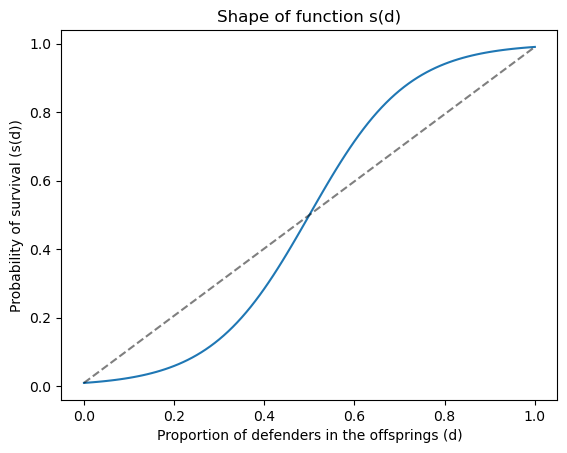

In [287]:
#The current shape of function s used for the simulations
d = np.linspace(0, 1, 101)
plt.plot(d, s(d))
plt.plot(d, np.linspace(0.01, 0.99, 101), 'k--', alpha = 0.5)
plt.xlabel('Proportion of defenders in the offsprings (d)')
plt.ylabel('Probability of survival (s(d))')
plt.title('Shape of function s(d)')

In [288]:
#Non matings
def f00(u, x00, C): #Results: M0 (1)
    return u * x00 * C * s(0)

def f01(u, x01, C): #Results: M0 (0.5), M1 (0.5)
    S = 0
    for k in range(C+1):
        S += comb(C, k) * (((0.5)**(k))*((0.5)**(C-k))) * s(k/C)

    return u * x01 * C * S

def f11(u, x11, c): #Results M1 (1)
    return u * x11 * c * s(1)

#Matings
def f00m0(u, x00, y0, C): #Results: F00 (1-r), M0 (r)
    return (1-u) * x00 * y0 * C * s(0)

def f11m1(u, x11, y1, c): #Results: F11 (1-r), M1 (r)
    return (1-u) * x11 * y1 * c * s(1)

def f00m1(u, x00, y1, C): #Results: F01 (1-r), M0 (r)
    return (1-u) * x00 * y1 * C * s(0)

def f11m0(u, x11, y0, c, r): #Results: F01 (1-r), M1(r)
    S = 0
    for k in range(c+1):
        S += comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * s(k/c)

    return (1-u) * x11 * y0 * c * S

def f01m0(u, x01, y0, C, r): #Results: F01 (1-r * 0.5), F00 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    S = 0
    for k in range(C+1):
        for m in range(k+1):
            for f in range(C-k+1):
                S += comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * comb(k, m) * (2 ** -k) * comb(C-k, f) * (2 ** (k-C)) * s(m/C)

    return (1-u) * x01 * y0 * C * S

def f01m1(u, x01, y1, C, r): #Results: F01 (1-r * 0.5), F11 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    S = 0
    for k in range(C+1):
        for m in range(k+1):
            for f in range(C-k+1):
                S += comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * comb(k, m) * (2 ** -k) * comb(C-k, f) * (2 ** (k-C)) * s((f+m)/C)

    return (1-u) * x01 * y1 * C * S

In [289]:
#Next Generation
def nexgen(P):
    #Initial frequencies of all genotypes
    #Males
    x0 = P['q']
    x1 = P['p']

    y0 = P['a']*x0 / (P['a']*x0 + x1)
    y1 = x1 / (P['a']*x0 + x1)

    #Females (Assuming equilibrium values)
    x00 = P['q']*P['q']
    x01 = 2*P['p']*P['q']
    x11 = P['p']*P['p']

    #New generation
    #Males
    x0_n = f00(P['u'], x00, P['C']) + (0.5) * f01(P['u'], x01, P['C']) + P['r'] * (f00m0(P['u'], x00, y0, P['C']) + f00m1(P['u'], x00, y1, P['C']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['r'])))

    x1_n = f11(P['u'], x11, P['c']) + (0.5) * f01(P['u'], x01, P['C']) + P['r'] * (f11m1(P['u'], x11, y1, P['c']) + f11m0(P['u'], x11, y0, P['c'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['r'])))

    #Females
    x00_n = (1 - P['r']) * (f00m0(P['u'], x00, y0, P['C']) + (0.5) * f01m0(P['u'], x01, y0, P['C'], P['r']))

    x11_n = (1 - P['r']) * (f11m1(P['u'], x11, y1, P['c']) + (0.5) * f01m1(P['u'], x01, y1, P['C'], P['r']))

    x01_n = (1 - P['r']) * (f00m1(P['u'], x00, y1, P['C']) + f11m0(P['u'], x11, y0, P['c'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['r'])))
    

    #Calculating the number of each allele in new gen
    n0 = x0_n + 2*x00_n + x01_n
    n1 = x1_n + 2*x11_n + x01_n

    #Calculating ratios
    p_new = n1/(n0+n1)
    q_new = n0/(n0+n1)

    return p_new, q_new

Text(0.5, 1.0, 'Change in p with alpha')

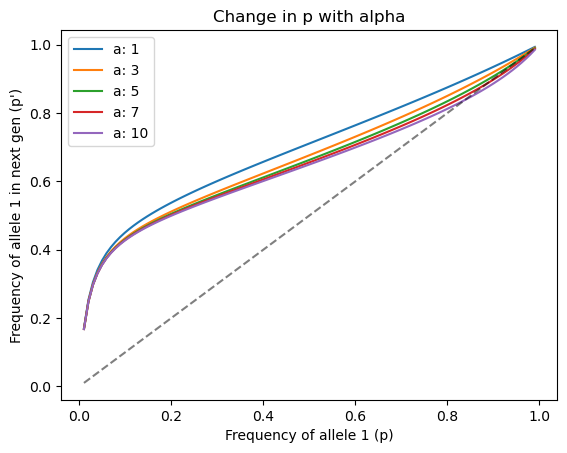

In [290]:
p_ls = []
q_ls = []

#Iterating over a range of values for alpha
for i in a:
    param = P
    param['a'] = i

    p_n, q_n = nexgen(param)

    p_ls.append(p_n)
    q_ls.append(q_n)

for i in range(a.shape[0]):
    plt.plot(p, p_ls[i], label = 'a: ' + str(a[i]))
plt.plot(p, p, 'k--', alpha=0.5)
plt.legend()
plt.xlabel("Frequency of allele 1 (p)")
plt.ylabel("Frequency of allele 1 in next gen (p')")
plt.title('Change in p with alpha')

Text(0.5, 1.0, 'Change in p with sex ratio')

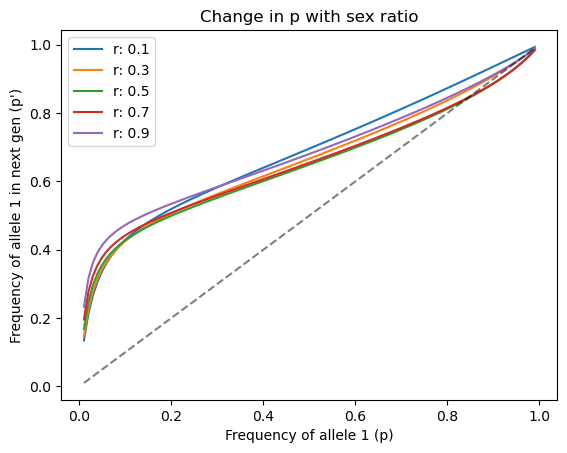

In [291]:
p_ls = []
q_ls = []

#Iterating over range of values for sex ratios
for i in r:
    param = P
    param['r'] = i

    p_n, q_n = nexgen(P)

    p_ls.append(p_n)
    q_ls.append(q_n)

for i in range(r.shape[0]):
    plt.plot(p, p_ls[i], label = 'r: ' + str(r[i]))
plt.plot(p, p, 'k--', alpha=0.5)
plt.legend()
plt.xlabel("Frequency of allele 1 (p)")
plt.ylabel("Frequency of allele 1 in next gen (p')")
plt.title('Change in p with sex ratio')

Text(0.5, 1.0, 'Change in p with c')

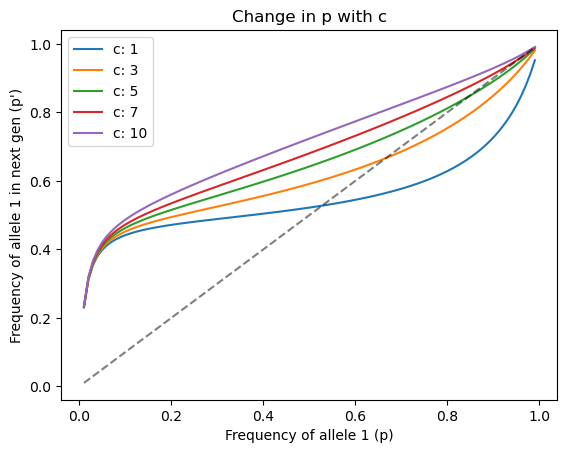

In [292]:
p_ls = []
q_ls = []

#Iterating over range of values for eggs laid by defender females
for i in c:
    param = P
    param['c'] = i

    p_n, q_n = nexgen(P)

    p_ls.append(p_n)
    q_ls.append(q_n)

for i in range(c.shape[0]):
    plt.plot(p, p_ls[i], label = 'c: ' + str(c[i]))
plt.plot(p, p, 'k--', alpha=0.5)
plt.legend()
plt.xlabel("Frequency of allele 1 (p)")
plt.ylabel("Frequency of allele 1 in next gen (p')")
plt.title('Change in p with c')

Text(0.5, 1.0, 'Change in p with u')

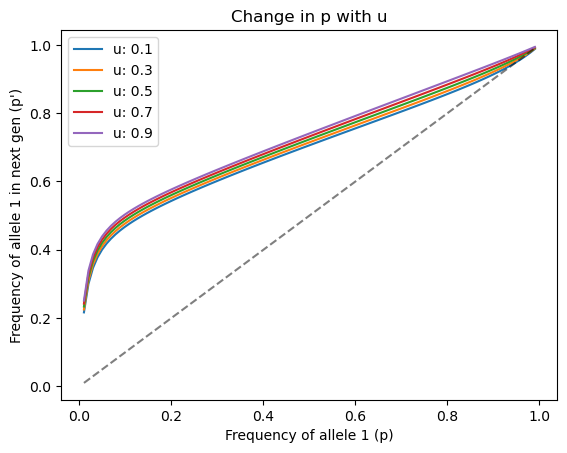

In [293]:
p_ls = []
q_ls = []

#Iterating over range of values for mating probability
for i in u:
    param = P
    param['u'] = i

    p_n, q_n = nexgen(P)

    p_ls.append(p_n)
    q_ls.append(q_n)

for i in range(u.shape[0]):
    plt.plot(p, p_ls[i], label = 'u: ' + str(u[i]))
plt.plot(p, p, 'k--', alpha=0.5)
plt.legend()
plt.xlabel("Frequency of allele 1 (p)")
plt.ylabel("Frequency of allele 1 in next gen (p')")
plt.title('Change in p with u')